In [1]:
import sys
sys.path.append("../") 

from src.utils.driver import set_seed

set_seed(57)

### Define Model and Dataset

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from src.utils.model import DistLayer

# Define the model class
class SimpleNN(nn.Module):
    def __init__(self, harmonic=False):
        super(SimpleNN, self).__init__()
        self.harmonic = harmonic
        if harmonic:
            self.fc1 = DistLayer(28 * 28, 10, n=28.)
        else:
            self.fc1 = nn.Linear(28 * 28, 10)
        nn.init.normal_(self.fc1.weight, mean=0, std=1/28.)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.fc1(x)
        if self.harmonic:
            prob = x/torch.sum(x, dim=1, keepdim=True)
            logits = (-1)*torch.log(prob)
            return logits
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
learning_rate = 0.001
max_epochs = 100

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/home/kayaba_attribution/.virtualenvs/ds/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 26421880/26421880 [00:01<00:00, 15068689.62it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 252901.20it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4872601.41it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20011378.12it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### Harmonic Model

In [3]:
# Initialize the model, loss function, and optimizer
model = SimpleNN(harmonic=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

patience = 10
min_delta = 1e-4
best_loss = 1e9

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = outputs[range(targets.size(0)), targets].mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
        
    # Early stopping check
    if epoch_loss < best_loss - min_delta:
        best_loss = epoch_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch % 10 == 0:
        print(f"Epoch [{epoch + 1}], Loss: {running_loss / len(train_loader):.4f}")

    if epochs_no_improve >= patience:
        print(f"Stopping training. No improvement for {patience} epochs.")
        break

# Evaluation
model.eval()
correct = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = (-1)*model(data)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()

accuracy = correct / len(test_dataset) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), "../results/fashion_mnist_harmonic.pth")

Epoch [1], Loss: 0.7699
Epoch [11], Loss: 0.4172
Epoch [21], Loss: 0.3964
Epoch [31], Loss: 0.3887
Epoch [41], Loss: 0.3850
Epoch [51], Loss: 0.3829
Epoch [61], Loss: 0.3822
Epoch [71], Loss: 0.3816
Epoch [81], Loss: 0.3812
Epoch [91], Loss: 0.3815
Stopping training. No improvement for 10 epochs.
Test Accuracy: 84.60%


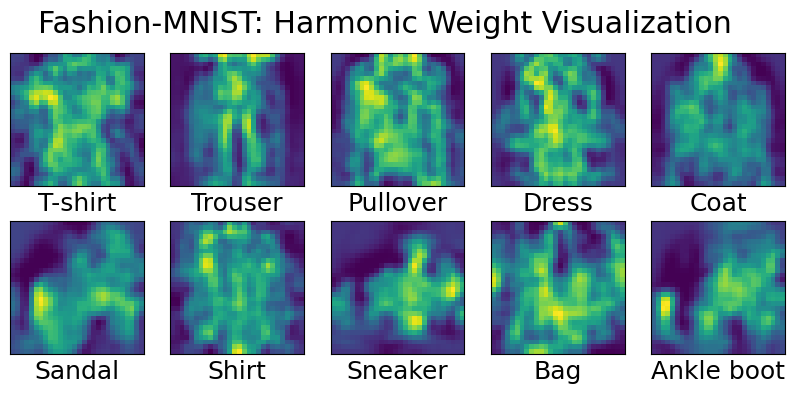

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

weights = torch.load("../results/fashion_mnist_harmonic.pth")

# Define Fashion-MNIST class labels
class_labels = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(2, 5, figsize=(10, 4))
plt.suptitle("Fashion-MNIST: Harmonic Weight Visualization")
for i in range(10):
    plt.subplot(2, 5, i + 1)
    weight = weights['fc1.weight'][i].cpu().reshape(28, 28).detach().numpy()
    # Normalize and enhance contrast
    weight = (weight - weight.min()) / (weight.max() - weight.min())
    # Adaptive thresholding
    threshold = np.percentile(weight, 10)
    weight = np.clip((weight - threshold) / (1 - threshold), 0, 1)
    # Apply Gaussian blur to smooth noise
    weight = cv2.GaussianBlur(weight, (3, 3), 0)

    # Use a better colormap
    plt.imshow(weight)
    
    # Add class label below each image
    plt.xlabel(class_labels[i])
    plt.xticks([])
    plt.yticks([])

plt.savefig("../figures/fashion_mnist_harmonic_weights.pdf", bbox_inches="tight")

### Standard Model

In [6]:
# Initialize the model, loss function, and optimizer
model = SimpleNN(harmonic=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

patience = 10
min_delta = 1e-4
best_loss = 1e9

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
        
    # Early stopping check
    if epoch_loss < best_loss - min_delta:
        best_loss = epoch_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch % 10 == 0:
        print(f"Epoch [{epoch + 1}], Loss: {running_loss / len(train_loader):.4f}")

    if epochs_no_improve >= patience:
        print(f"Stopping training. No improvement for {patience} epochs.")
        break

# Evaluation
model.eval()
correct = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()

accuracy = correct / len(test_dataset) * 100
print(f"Test Accuracy: {accuracy:.2f}%")
torch.save(model.state_dict(), "../results/mnist_standard.pth")


Epoch [1], Loss: 0.6509
Epoch [11], Loss: 0.3945
Epoch [21], Loss: 0.3798
Epoch [31], Loss: 0.3728
Epoch [41], Loss: 0.3672
Epoch [51], Loss: 0.3646
Epoch [61], Loss: 0.3628
Epoch [71], Loss: 0.3614
Epoch [81], Loss: 0.3597
Epoch [91], Loss: 0.3588
Test Accuracy: 84.12%


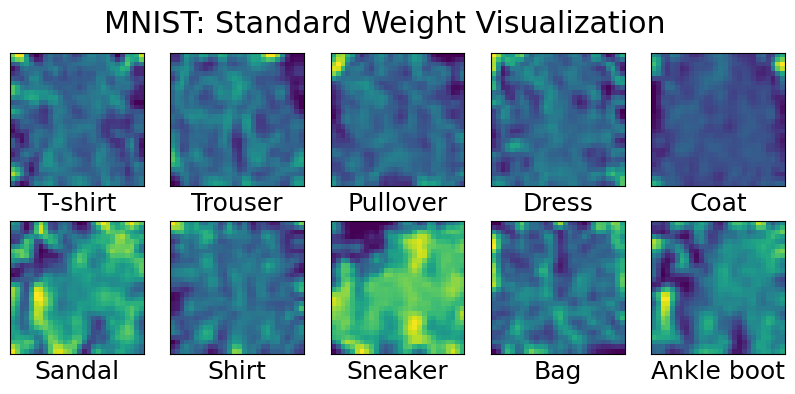

In [44]:
import matplotlib.pyplot as plt
import numpy as np

weights = torch.load("../results/fashion_mnist_standard.pth")

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
plt.suptitle("MNIST: Standard Weight Visualization")
for i in range(10):
    plt.subplot(2, 5, i + 1)
    weight = weights['fc1.weight'][i].cpu().reshape(28, 28).detach().numpy()
    # Normalize and enhance contrast
    weight = (weight - weight.min()) / (weight.max() - weight.min())
    # Adaptive thresholding
    threshold = np.percentile(weight, 10)
    # weight = np.where(weight < threshold, 0, weight)
    weight = np.clip((weight - threshold) / (1 - threshold), 0, 1)
    # Apply Gaussian blur to smooth noise
    weight = cv2.GaussianBlur(weight, (3, 3), 0)

    plt.imshow(weight)
    plt.xlabel(class_labels[i])
    plt.xticks([])
    plt.yticks([])

#plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig("../figures/fashion_mnist_standard_weights.pdf", bbox_inches="tight")